# Scoring model based on random forest

In [1]:
import os
import warnings
import time

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import optuna
from category_encoders import WOEEncoder
from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import (
    RepeatedStratifiedKFold,
    StratifiedKFold,
    cross_validate,
    cross_val_score
)
from sklearn.pipeline import Pipeline

# Global parameters
N_SPLITS = 5
N_REPEATS = 10
SEED = 42
TRIALS = 150

# Settings
np.set_printoptions(formatter={"float": lambda x: "{0:0.4f}".format(x)})  # `standard number format` mode
pd.set_option("display.max_columns", None)                                # `show whole df` mode
warnings.filterwarnings("ignore")                                         # `do not disturbe` mode
sns.set_context("paper", font_scale=1.4)                                  # sns font
sns.set_style("darkgrid")                                                 # sns theme

In [2]:
def objective(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 50),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 50),
        "max_features": trial.suggest_categorical("max_features", ["auto", "sqrt", "log2", None]),
        "class_weight": trial.suggest_categorical("class_weight", ["balanced", "balanced_subsample", None]),
    }
    
    model = RandomForestClassifier(**param, random_state=SEED)

    # Cross-validation
    cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
    scores = cross_val_score(model, X_train, np.ravel(y_train), scoring="roc_auc", cv=cv)
    mean_val_auc = scores.mean()

    return mean_val_auc * 2 - 1

In [3]:
# Load data
X_train = pd.read_csv(os.path.join("Data", "data_preprocessed", "taiwan_data", "X_train.csv"))
X_test = pd.read_csv(os.path.join("Data", "data_preprocessed", "taiwan_data", "X_test.csv"))
y_train = pd.read_csv(os.path.join("Data", "data_preprocessed", "taiwan_data", "y_train.csv"))
y_test = pd.read_csv(os.path.join("Data", "data_preprocessed", "taiwan_data", "y_test.csv"))

print(X_train.shape)
print(X_test.shape)

(20000, 23)
(10000, 23)


### Feature selection

In [4]:
%%time
# Initial hyperparameters optimization
study = optuna.create_study(directions=["maximize"])
study.optimize(objective, n_trials=TRIALS, n_jobs=-1)
print(study.best_params)

[I 2021-05-25 14:25:26,280] A new study created in memory with name: no-name-2a87b1f9-3c27-44b2-b665-ba6adb812f05
[I 2021-05-25 14:25:47,428] Trial 0 finished with value: 0.5603379344530885 and parameters: {'n_estimators': 109, 'criterion': 'gini', 'max_depth': 9, 'min_samples_split': 44, 'min_samples_leaf': 45, 'max_features': 'log2', 'class_weight': None}. Best is trial 0 with value: 0.5603379344530885.
[I 2021-05-25 14:25:49,634] Trial 2 finished with value: 0.5449310964271308 and parameters: {'n_estimators': 209, 'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 12, 'min_samples_leaf': 29, 'max_features': 'log2', 'class_weight': None}. Best is trial 0 with value: 0.5603379344530885.
[I 2021-05-25 14:26:04,543] Trial 1 finished with value: 0.5452820667528824 and parameters: {'n_estimators': 245, 'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 36, 'min_samples_leaf': 34, 'max_features': 'sqrt', 'class_weight': None}. Best is trial 0 with value: 0.5603379344530885

{'n_estimators': 206, 'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 31, 'min_samples_leaf': 49, 'max_features': 'sqrt', 'class_weight': None}
Wall time: 34min 21s


In [5]:
# Sequential feature selection
model = RandomForestClassifier(**study.best_params, random_state=SEED)

cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
sfs = SequentialFeatureSelector(
    model,
    k_features=23,
    forward=True,
    floating=True,
    scoring="roc_auc",
    verbose=2,
    cv=cv,
    n_jobs=-1,
)

sfs = sfs.fit(X_test, y_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:  1.2min finished

[2021-05-25 15:00:59] Features: 1/23 -- score: 0.7114870791385071[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:   59.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.2s finished

[2021-05-25 15:02:11] Features: 2/23 -- score: 0.7414893266477846[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:  1.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    7.8s finished

[2021-05-25 15:03:38] Features: 3/23 -- score: 0.7659923232938197[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent 

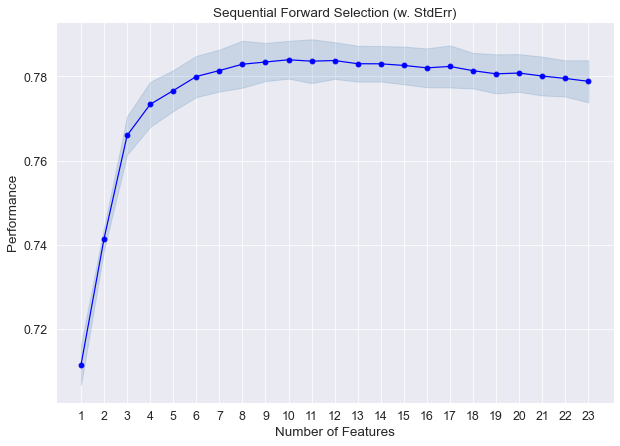

In [6]:
# Plot SFS chart
fig = plot_sfs(sfs.get_metric_dict(), kind="std_err", figsize=[10, 7])
plt.title("Sequential Forward Selection (w. StdErr)")

plt.savefig(os.path.join("Experiment_results", "RandomForest", "rf_SFS.png"), facecolor="w")

In [7]:
# Print chosen variables
results = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
final_variables = list(results["feature_names"][10])
final_variables

['LIMIT_BAL',
 'MARRIAGE',
 'PAY_0',
 'PAY_2',
 'PAY_3',
 'PAY_5',
 'PAY_6',
 'BILL_AMT1',
 'BILL_AMT2',
 'PAY_AMT3']

In [8]:
# Drop unused variables
X_train = X_train[final_variables]
X_test = X_test[final_variables]

### Model

In [9]:
%%time
start = time.time()

# Hyperparameters optimization
study = optuna.create_study(directions=["maximize"])
study.optimize(objective, n_trials=TRIALS, n_jobs=-1)

end = time.time()
optimization_time = end-start

print(study.best_params)

# Model definition
model = RandomForestClassifier(**study.best_params, random_state=SEED)

[I 2021-05-25 16:22:26,338] A new study created in memory with name: no-name-bd58dca4-8017-4870-953d-50a68c86ccf7
[I 2021-05-25 16:22:33,980] Trial 0 finished with value: 0.5370132944726413 and parameters: {'n_estimators': 64, 'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 30, 'min_samples_leaf': 1, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.5370132944726413.
[I 2021-05-25 16:23:02,607] Trial 2 finished with value: 0.5526613154958067 and parameters: {'n_estimators': 280, 'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 15, 'min_samples_leaf': 39, 'max_features': 'auto', 'class_weight': None}. Best is trial 2 with value: 0.5526613154958067.
[I 2021-05-25 16:23:15,483] Trial 4 finished with value: 0.5578212338055208 and parameters: {'n_estimators': 194, 'criterion': 'entropy', 'max_depth': 8, 'min_samples_split': 26, 'min_samples_leaf': 34, 'max_features': 'auto', 'class_weight': None}. Best is trial 4 with value: 0.557821233

{'n_estimators': 277, 'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 42, 'min_samples_leaf': 35, 'max_features': 'sqrt', 'class_weight': None}
Wall time: 37min 41s


In [10]:
# Cross-validation
cv = RepeatedStratifiedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=SEED)
scores = cross_validate(
    model, X_train, np.ravel(y_train), scoring="roc_auc", cv=cv, return_train_score=True, n_jobs=-1
)
mean_train_auc = scores["train_score"].mean()
mean_val_auc = scores["test_score"].mean()
std_val_auc = scores["test_score"].std()

# Test
model.fit(X=X_train, y=np.ravel(y_train))
preds = model.predict_proba(X_test)[::, 1]
test_auc = metrics.roc_auc_score(y_test, preds)
ap = metrics.average_precision_score(y_test, 1-preds, pos_label=0)

# Print the results
print(f"mean_train_GINI:\t {np.round(mean_train_auc * 2 - 1, 4)}")
print("mean_dev_GINI:\t\t", np.round(mean_val_auc * 2 - 1, 4), f"({np.round(std_val_auc, 4)})")
print(f"test_GINI:\t\t {np.round(test_auc * 2 - 1, 4)}")
print(f"AP:\t\t\t {np.round(ap, 4)}")

mean_train_GINI:	 0.6253
mean_dev_GINI:		 0.5604 (0.0088)
test_GINI:		 0.5709
AP:			 0.5671


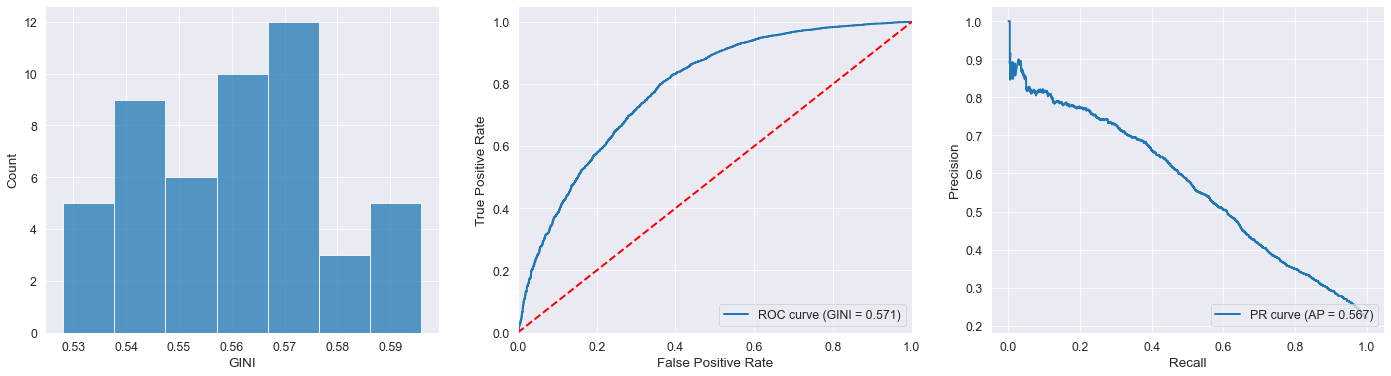

In [11]:
# Boxplot
fig, axs = plt.subplots(1, 3, figsize=(24, 6))
fig1 = sns.histplot(scores["test_score"] * 2 - 1, ax=axs[0])
fig1.set_xlabel("GINI")

# ROC
preds = model.predict_proba(X_test)[::, 1]
test_auc = metrics.roc_auc_score(y_test, preds)

fpr, tpr, _ = metrics.roc_curve(y_test, preds)
lw = 2
axs[1].plot(fpr, tpr, lw=lw, label="ROC curve (GINI = %0.3f)" % (test_auc * 2 - 1))
axs[1].plot([0, 1], [0, 1], color="red", lw=lw, linestyle="--")
axs[1].set_xlim([0.0, 1.0])
axs[1].set_ylim([0.0, 1.05])
axs[1].set_xlabel("False Positive Rate")
axs[1].set_ylabel("True Positive Rate")
axs[1].legend(loc="lower right")

# PR
precision, recall, _ = metrics.precision_recall_curve(y_test, 1-preds, pos_label=0)
lw = 2
axs[2].plot(recall, precision, lw=lw, label="PR curve (AP = %0.3f)" % ap)
axs[2].set_xlabel("Recall")
axs[2].set_ylabel("Precision")
axs[2].legend(loc="lower right")

plt.savefig(os.path.join("Experiment_results", "RandomForest", "rf_cv_roc.png"), facecolor="w")

In [12]:
# Save results for final summary
res = {
    "val_scores": scores["test_score"] * 2 - 1,
    "fpr_tpr": [fpr, tpr],
    "pr_rec": [precision, recall],
    "test_gini": test_auc * 2 - 1,
    "dev_gini": [mean_val_auc * 2 - 1, std_val_auc],
    "optimization_time": optimization_time,
    "ap": ap,
}

joblib.dump(res, os.path.join("Experiment_results", "RandomForest", "rf_res.pth"))

['Experiment_results\\RandomForest\\rf_res.pth']

                      0       1      2      3      4      5       6       7       8       9       10      11
score_calibrated  593.00  580.00  612.0  581.0  590.0  575.0  592.00  591.00  582.00  588.00  600.00  583.00
%Agreements         1.32    1.28    1.2    1.2    1.2    1.2    1.16    1.13    1.12    1.11    1.09    1.07


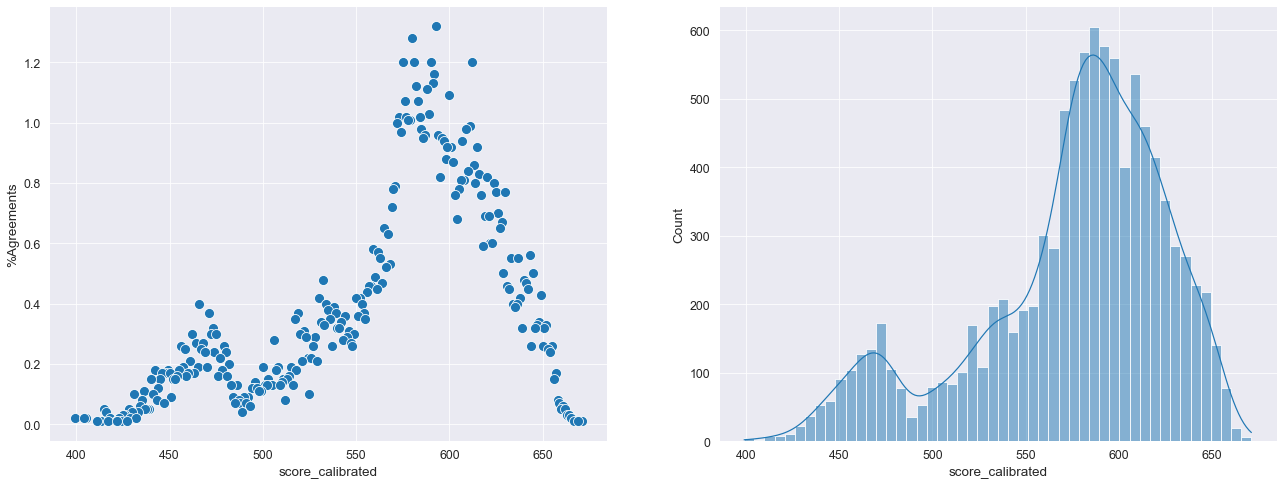

In [13]:
# Score distribution
preds_calibrated = pd.DataFrame(np.round(50*np.log(preds/(1-preds))+500), columns=["score_calibrated"])

score_distr = preds_calibrated['score_calibrated'].value_counts()/preds_calibrated.shape[0]*100
score_distr_df = pd.concat([pd.Series(list(score_distr.index), name='score_calibrated'), pd.Series(list(score_distr), name='%Agreements')], axis=1)
print(score_distr_df.head(12).T.to_string())

fig, axs = plt.subplots(1, 2, figsize=(22,8))
sns.scatterplot(data=score_distr_df, x="score_calibrated", y="%Agreements", s=100, ax=axs[0])
sns.histplot(data=preds_calibrated, x="score_calibrated", kde=True, ax=axs[1])

plt.savefig(os.path.join("Experiment_results", "RandomForest", "rf_score_distr.png"), facecolor="w")

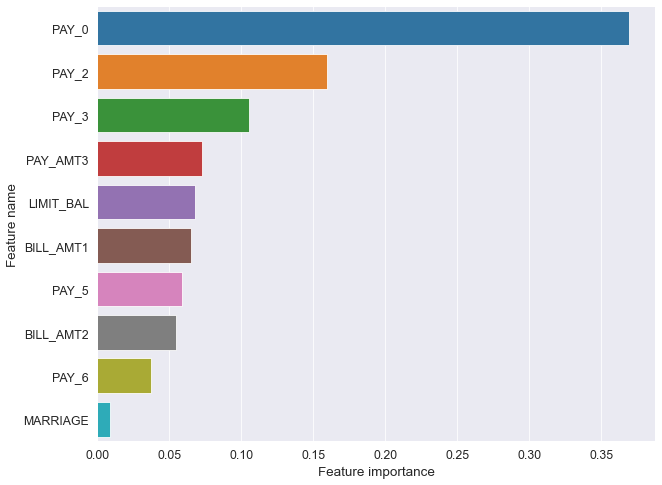

In [14]:
fi = pd.concat([pd.Series(X_train.columns.values, name='Feature name'), pd.Series(model.feature_importances_, name='Feature importance')], axis=1)\
        .sort_values('Feature importance', ascending=False)

fig, axs = plt.subplots(1, 1, figsize=[10,8])
sns.barplot(x='Feature importance', y='Feature name', data=fi)

plt.savefig(os.path.join("Experiment_results", "RandomForest", "rf_fi.png"), facecolor="w")

### Performance vs sample size

In [15]:
optuna.logging.set_verbosity(optuna.logging.FATAL) # optuna silent mode

In [16]:
# Examine relationship between model performance and sample size
n_sample = [50, 100, 500, 1000, 2000, 3000, 5000, 7000, 10000, 20000]

experiment = pd.DataFrame(n_sample, columns=["Training set size"])
experiment["Mean train GINI"] = np.NaN
experiment["Mean validation GINI"] = np.NaN
experiment["Std validation GINI"] = np.NaN
experiment["Test GINI"] = np.NaN

for i in range(len(n_sample)):
    X_train = pd.read_csv(os.path.join("Data", "data_preprocessed", "taiwan_data", "X_train.csv"))[final_variables]
    X_test = pd.read_csv(os.path.join("Data", "data_preprocessed", "taiwan_data", "X_test.csv"))[final_variables]
    y_train = pd.read_csv(os.path.join("Data", "data_preprocessed", "taiwan_data", "y_train.csv"))
    y_test = pd.read_csv(os.path.join("Data", "data_preprocessed", "taiwan_data", "y_test.csv"))

    if n_sample[i] < 20000:
        X_train = X_train.sample(n_sample[i], random_state=SEED)
        y_train = y_train.sample(n_sample[i], random_state=SEED)
        
    # Hyperparameters optimization
    study = optuna.create_study(directions=["maximize"])
    study.optimize(objective, n_trials=TRIALS, n_jobs=-1)
    print(study.best_params)

    # Model definition
    model = RandomForestClassifier(**study.best_params, random_state=SEED)    
        
    # Cross-validation
    cv = RepeatedStratifiedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=SEED)
    scores = cross_validate(model, X_train, np.ravel(y_train), scoring="roc_auc", cv=cv, return_train_score=True, n_jobs=-1)
    mean_train_auc = scores["train_score"].mean()
    mean_val_auc = scores["test_score"].mean()
    std_val_auc = scores["test_score"].std()

    # Test
    model.fit(X=X_train, y=np.ravel(y_train))
    preds = model.predict_proba(X_test)[::, 1]
    test_auc = metrics.roc_auc_score(y_test, preds)

    # Save the results to daraframe
    experiment["Mean train GINI"][i] = mean_train_auc * 2 - 1
    experiment["Mean validation GINI"][i] = mean_val_auc * 2 - 1
    experiment["Std validation GINI"][i] = std_val_auc
    experiment["Test GINI"][i] = test_auc * 2 - 1

{'n_estimators': 204, 'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 27, 'min_samples_leaf': 13, 'max_features': 'sqrt', 'class_weight': None}
{'n_estimators': 50, 'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 15, 'min_samples_leaf': 4, 'max_features': 'auto', 'class_weight': None}
{'n_estimators': 88, 'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 49, 'min_samples_leaf': 5, 'max_features': 'log2', 'class_weight': None}
{'n_estimators': 50, 'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 46, 'min_samples_leaf': 28, 'max_features': 'auto', 'class_weight': None}
{'n_estimators': 153, 'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 38, 'min_samples_leaf': 14, 'max_features': 'log2', 'class_weight': 'balanced_subsample'}
{'n_estimators': 159, 'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 15, 'min_samples_leaf': 33, 'max_features': 'auto', 'class_weight': None}
{'n_estimators': 153, 'criterion': 'gini', 'max_depth': 10

In [17]:
experiment

,Training set size,Mean train GINI,Mean validation GINI,Std validation GINI,Test GINI
0,50,0.594741,0.412202,0.173412,0.053063
1,100,0.837884,0.391676,0.097789,0.494867
2,500,0.710985,0.485634,0.047807,0.534418
3,1000,0.643165,0.516469,0.035259,0.545393
4,2000,0.678163,0.553225,0.022013,0.547255
5,3000,0.620740,0.532270,0.023205,0.552323
6,5000,0.646173,0.554203,0.017066,0.563215
7,7000,0.699051,0.555274,0.011805,0.557973
8,10000,0.642512,0.564850,0.010321,0.566269
9,20000,0.621735,0.560303,0.008764,0.570026


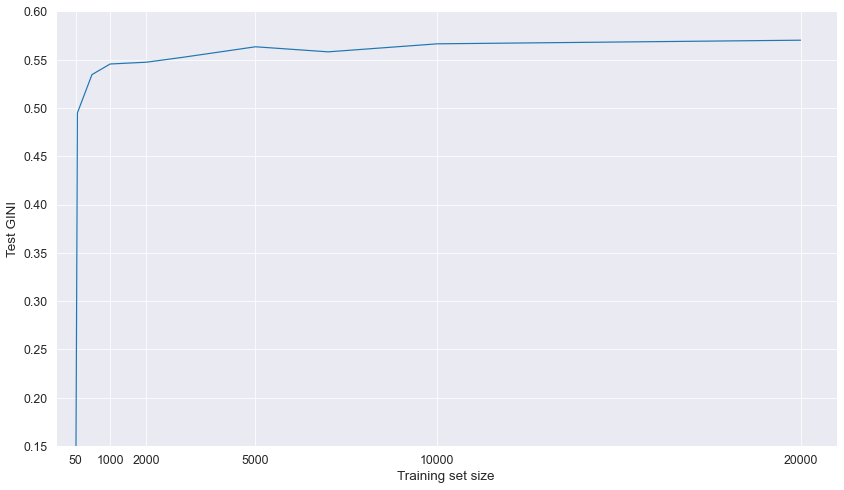

In [18]:
# Plot experiment results
fig, ax = plt.subplots(figsize=(14, 8))
sns.lineplot(data=experiment, x="Training set size", y="Test GINI")
ax.set_ylim([0.15, 0.6])
ax.set_xlim([-500, None])
ax.set_xticks([50, 1000, 2000, 5000, 10000, 20000])

In [19]:
# Save results for final summary
joblib.dump(experiment, os.path.join("Experiment_results", "RandomForest", "rf_experiment.pth"))

['Experiment_results\\RandomForest\\rf_experiment.pth']